In [1]:
import os

In [15]:
try:
    from PIL import Image, ImageDraw, ImageFont

    # name of the file to save
    filename = "img01.png"
    #fnt = ImageFont.truetype('arial.ttf', 15)
    fontsize=50
    fnt = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerifBold.ttf',fontsize)
    # create new image
    image = Image.new(mode = "RGB", size = (230,70), color = "white")
    draw = ImageDraw.Draw(image)
    draw.text((10,10), "SpatialPy", font=fnt, fill=(0,0,0))

    if not os.path.isfile('image.pkl'):
        import pickle
        with open('image.pkl','wb') as p:
            pickle.dump(image,p)

except ModuleNotFoundError:
    import pickle
    with open('image.pkl') as p:
        image = pickle.load(p)


In [16]:
!ls -l

total 3440
-rw-rw-r-- 1 brian brian 1938782 Jul  1 14:16 BoundaryCondition.ipynb
-rw-rw-r-- 1 brian brian   48363 Jul  1 17:05 image.pkl
-rw-rw-r-- 1 brian brian 1531721 Jul  1 16:58 Spatialpy_gravity.ipynb


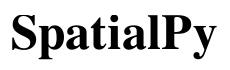

In [12]:
image

In [3]:
import numpy
import matplotlib.pyplot as plt

(2.8999999999999986, 225.1, 169.85, 217.15)

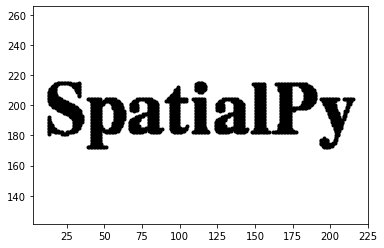

In [4]:
image_array = numpy.asarray(image)
word_points_x = []
word_points_y = []
#print("image_array.shape",image_array.shape)
for y in range(image_array.shape[0]):
    for x in range(image_array.shape[1]):
        if image_array[y,x,0] < 50:
            word_points_x.append(x)
            word_points_y.append(image_array.shape[1]-y)
#print('word_points_x',len(word_points_x))
#print('word_points_y',len(word_points_y))
plt.plot(word_points_x, word_points_y,'.k')
plt.axis('equal')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.insert(0,'../..')
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [33]:
class SpatialPyGravity(spatialpy.Model):
    def __init__(self,x_vals,y_vals, xmax, ymax):
        spatialpy.Model.__init__(self,"SpatialPyGravity")
        self.mesh = spatialpy.Mesh(len(x_vals), 
                        (0,xmax), (0,ymax), (0,0),
                        gravity=[0,-1,0])
        for i in range(len(x_vals)):
            self.mesh.vertices[i,0] = x_vals[i]
            self.mesh.vertices[i,1] = y_vals[i]
            self.mesh.sd[i] = 1
            self.mesh.mass[i] = 1.0
            self.mesh.vol[i] = 1.0
            self.mesh.nu[i] = 1.0

        # Define time parameters
        self.timestep_size = 1e-4  # timestep size
        self.num_timesteps = 5000    # number of timesteps
        self.output_freq = 500      # frequency of outputting results

        self.staticDomain = False

In [34]:
model = SpatialPyGravity(word_points_x,word_points_y,
                 image_array.shape[1],image_array.shape[0])

In [35]:
sol = spatialpy.Solver(model, debug_level=0)
%time sol.compile()

CPU times: user 29.5 s, sys: 112 ms, total: 29.6 s
Wall time: 33 s


In [36]:
%time result = sol.run()

CPU times: user 7.75 ms, sys: 4.06 ms, total: 11.8 ms
Wall time: 2min 39s


In [37]:
result.plot_property('type')

In [38]:
def plot_step(t_ndx,key='type', index=None):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    if index is None:
        plt.scatter(pts[:,0],pts[:,1],c=data[key])
    else:
        plt.scatter(pts[:,0],pts[:,1],c=data[key][index])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx*model.timestep_size*model.output_freq))

def plot_all(key='type',index=None):
    for i,t in enumerate(result.get_timespan()):
        plot_step(i,key,index=index)

In [39]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(time=0,key='type',index=0):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(time))
    #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)

    
def plot_all(key='type',index=0):
    for i,t in enumerate(result.get_timespan()):
        plot_step(i,key,index)

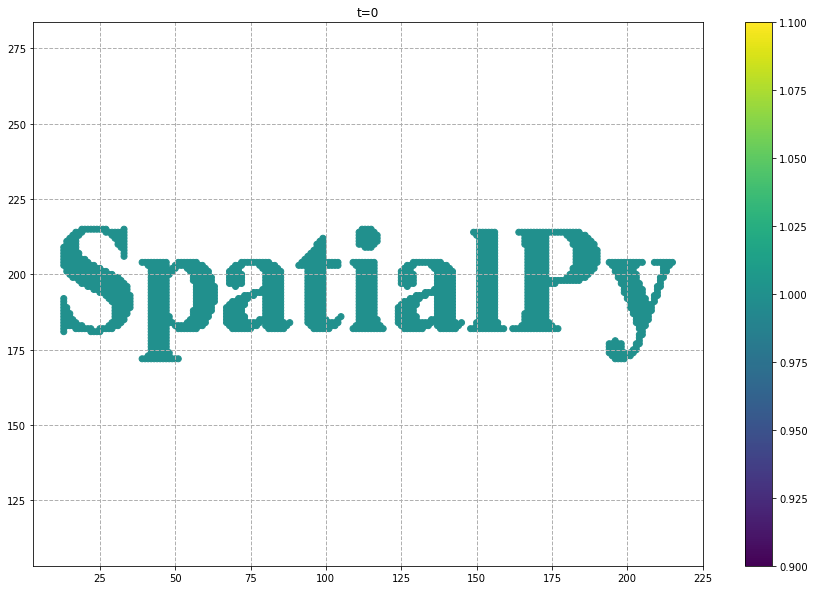

In [40]:
plot_step(0)

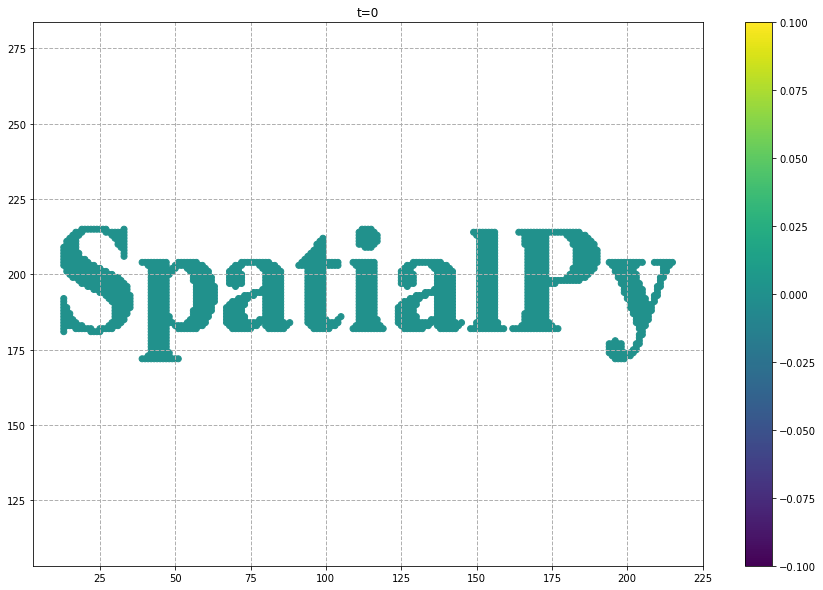

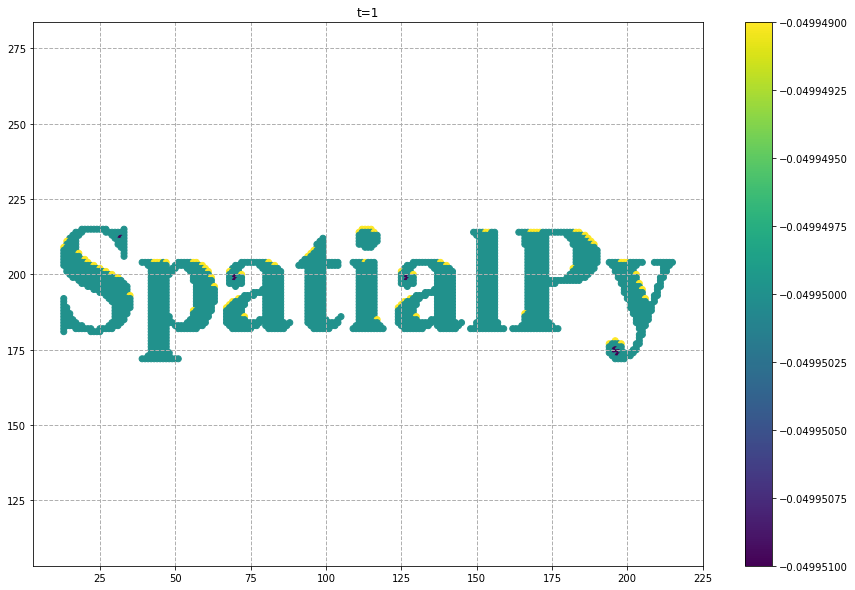

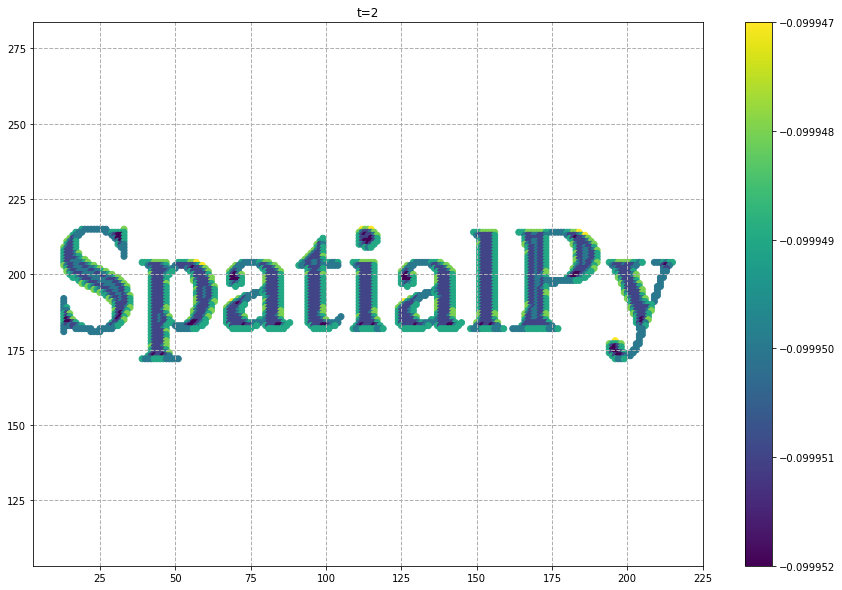

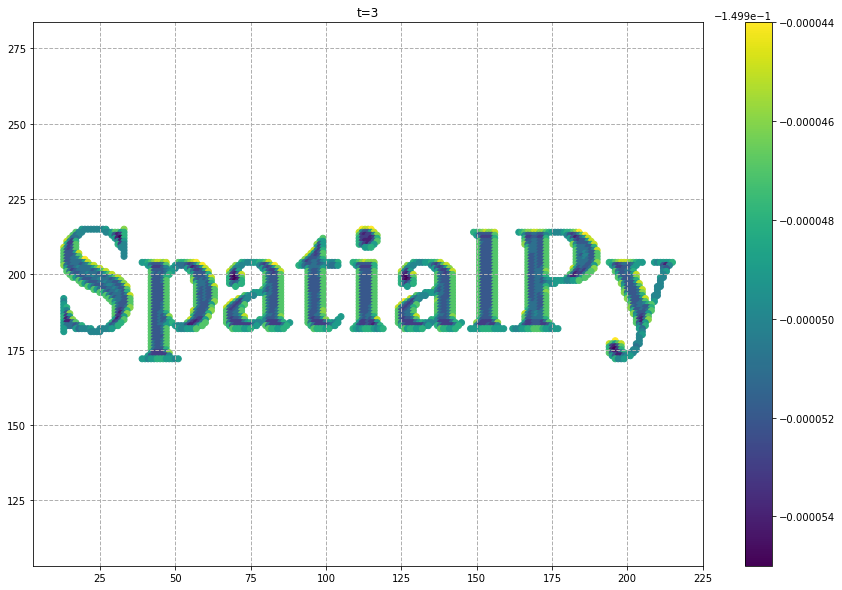

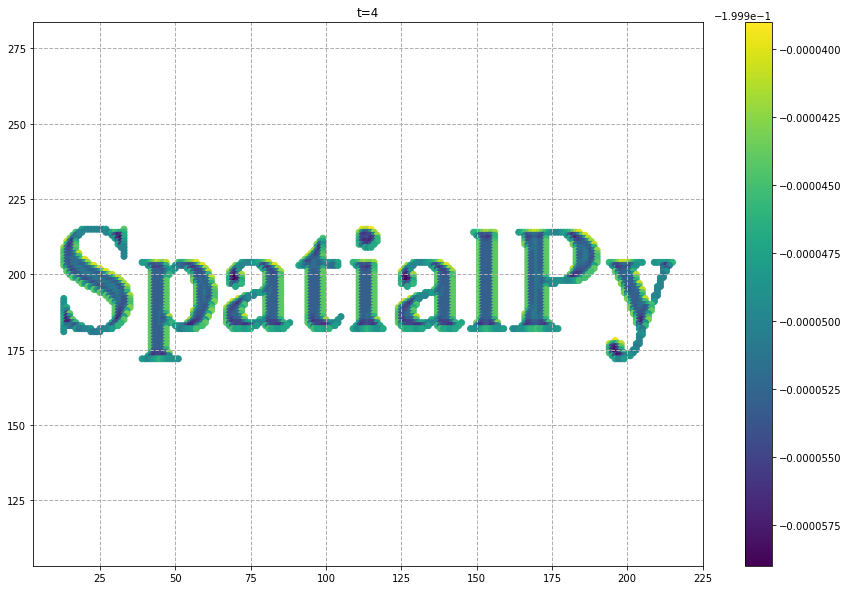

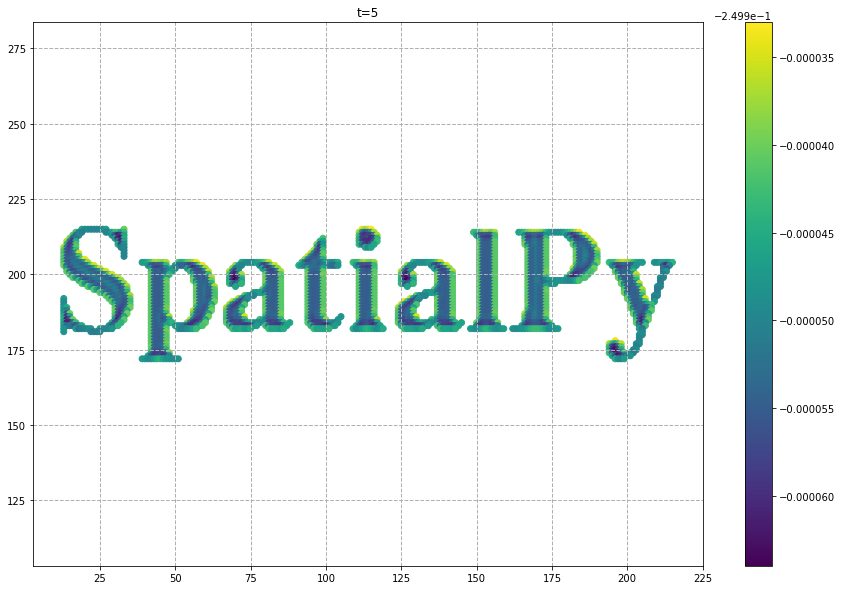

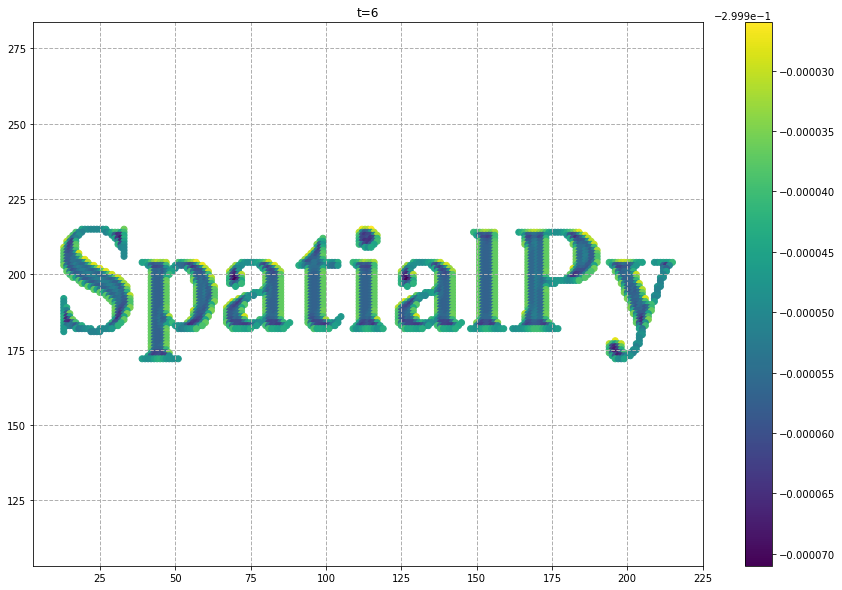

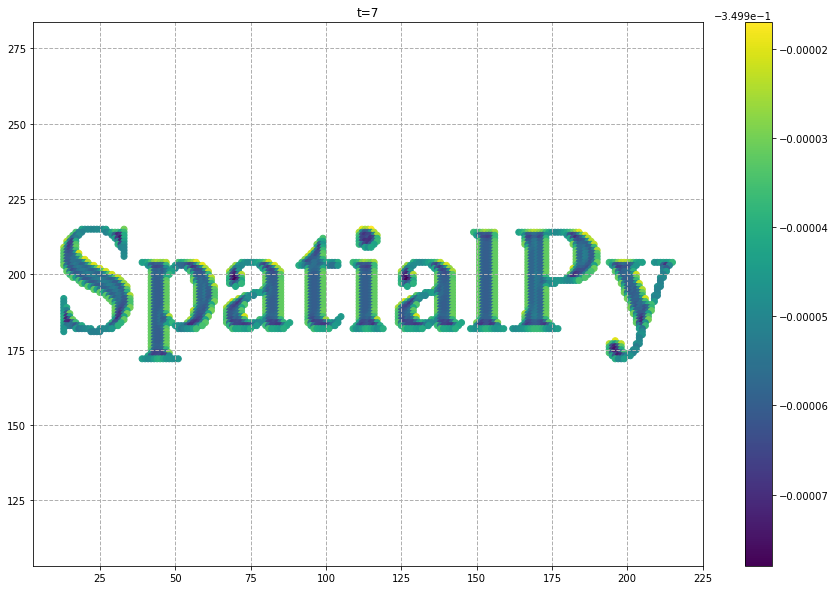

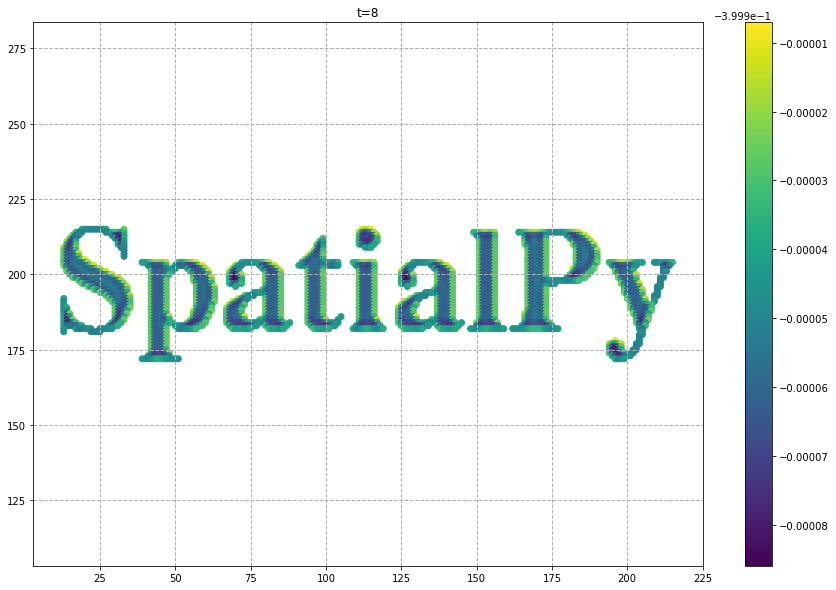

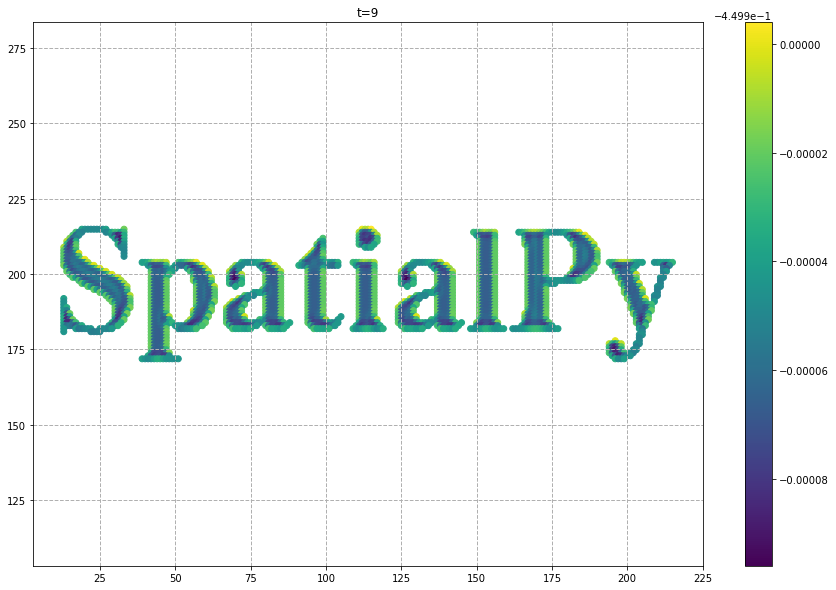

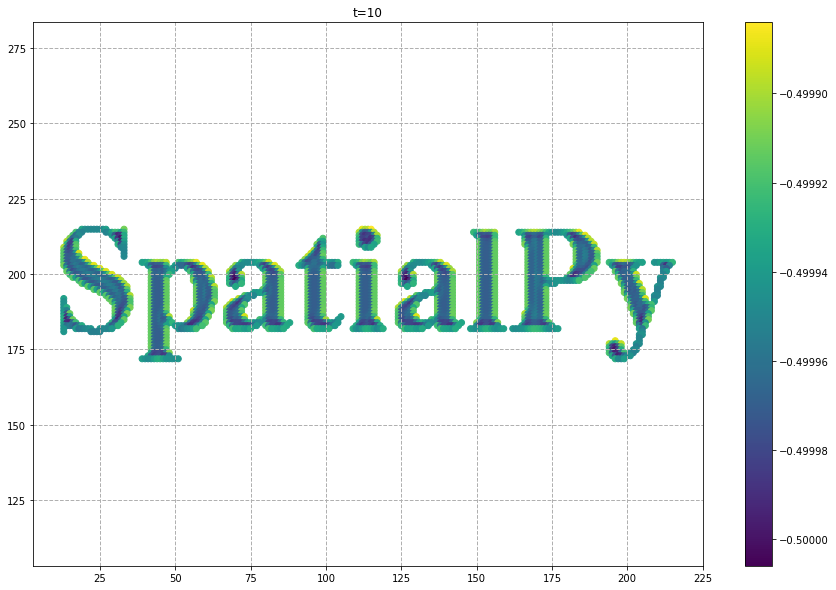

In [41]:
plot_all('v',index=1)